In [ ]:
import os
import numpy as np
import pandas as pd
import random
from tensorflow.keras.optimizers.schedules import PolynomialDecay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from IPython.core.display import HTML,display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import warnings
warnings.filterwarnings('ignore')
import re
import timeit
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
file_name = '/content/drive/MyDrive/Dataset/fakenews_data/dataset berita.csv'
df_data = pd.read_csv(file_name, sep=';')
df_data.head().append(df_data.tail())

,kategori,berita
0,valid,"""Gunung Agung erupsi untuk pertama kali pada 2..."
1,valid,"""Jakarta, CNN Indonesia -- Menteri BUMN Erick ..."
2,valid,"""Dosen Fakultas Kedokteran Hewan IPB, Yusuf Ri..."
3,valid,"""Jakarta - Dua anggota TNI, Serda N dan Serda ..."
4,valid,"""Akui Tembak Jatuh Pesawat Ukraina, Iran Tuai ..."
1095,valid,Kabar yang beredar seputar rencana kenaikan ga...
1096,valid,Kabar yang beredar seputar rencana kenaikan ga...
1097,valid,"Akhir-akhir ini, beredar pemberitaan yang meny..."
1098,valid,Rancangan peraturan pemerintah (RPP) tentang G...
1099,valid,Kabar yang beredar seputar rencana kenaikan ga...


In [ ]:
df_data.isnull().sum()

kategori    0
berita      0
dtype: int64

In [ ]:
df_data['kategori'].value_counts()

valid    622
hoax     478
Name: kategori, dtype: int64

In [ ]:
df_data['text_word_count']=df_data['berita'].apply(lambda x:len(x.split()))

#Data Preparation

In [ ]:
df_data['kategori'] = df_data['kategori'].replace(['valid'],0)
df_data['kategori'] = df_data['kategori'].replace(['hoax'],1)

#Data Visualisation

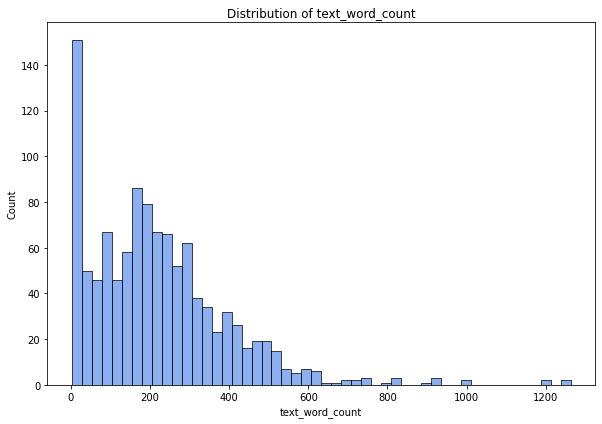

In [ ]:
numerical_feature_cols=['text_word_count']
plt.figure(figsize=(24,6))
for i,col in enumerate(numerical_feature_cols):
    plt.subplot(1,3,i+1)
    sns.histplot(data=df_data,x=col,bins=50,color='#6495ED')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

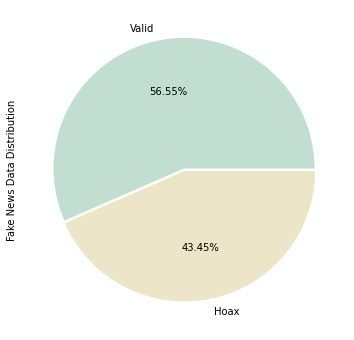

In [ ]:
plt.figure(figsize=(10,6))
colors=['#C2DED1','#ECE5C7']
plt.pie(df_data['kategori'].value_counts(),labels=['Valid','Hoax'],autopct='%.2f%%',explode=[0.01,0.01],colors=colors);
plt.ylabel('Fake News Data Distribution');

Valid rating worldcloud

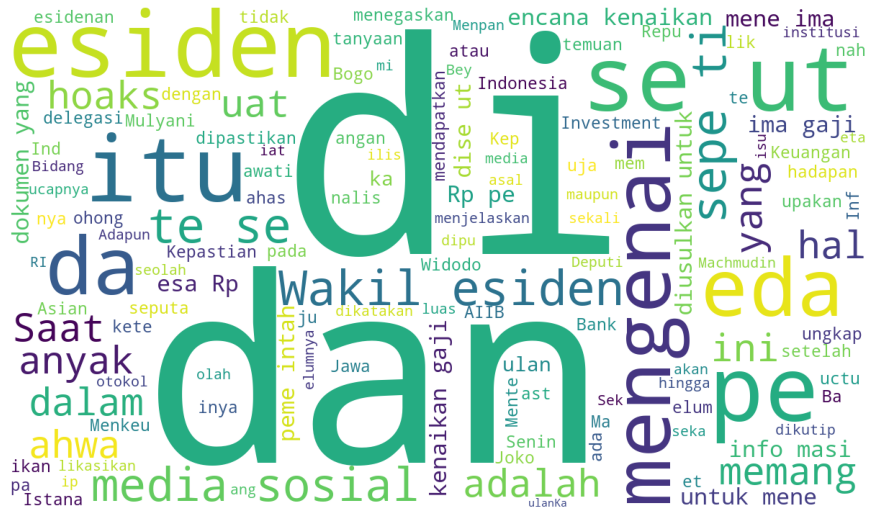

In [ ]:
text_list=df_data.loc[df_data['kategori']==0,'berita'].tolist()
text=""
for sent in text_list:
    sent=re.sub("[<br>]"," ",sent)
    text=re.sub("[^A-Za-z0-9]+"," ",sent)
    text+=sent    

stopwords=set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)
 
# plot the WordCloud image                      
plt.figure(figsize = (12, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

Hoax rating worldcloud

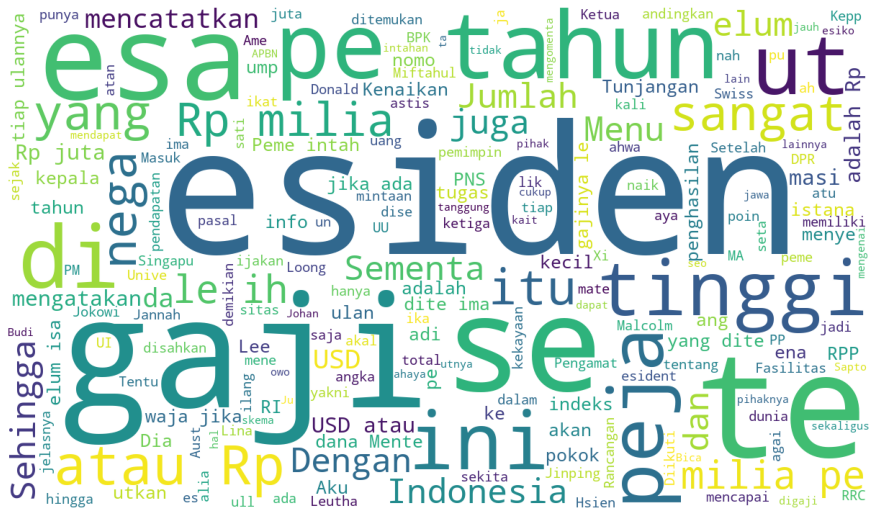

In [ ]:
text_list=df_data.loc[df_data['kategori']==1,'berita'].tolist()
text=""
for sent in text_list:
    sent=re.sub("[<br>]"," ",sent)
    text=re.sub("[^A-Za-z0-9]+"," ",sent)
    text+=sent    

stopwords=set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)
 
# plot the WordCloud image                      
plt.figure(figsize = (12, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Data Preprocessing

In [ ]:

xtrain, xtest, ytrain, ytest = train_test_split(df_data['berita'].to_numpy(),df_data['kategori'].to_numpy(),test_size=0.2,stratify=df_data['kategori'].to_numpy())

In [ ]:

Counter(ytrain),Counter(ytest)

(Counter({0: 498, 1: 382}), Counter({0: 124, 1: 96}))

In [ ]:
#
training_dataset=tf.data.Dataset.from_tensor_slices((xtrain,ytrain)).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)
test_dataset=tf.data.Dataset.from_tensor_slices((xtest,ytest)).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

tokenization & vectorization

In [ ]:

max_vocab_length=10000

max([len(x.split()) for x in xtrain])

1263

In [ ]:
selected_news_length=round(np.percentile(([len(x.split()) for x in xtrain]),95))
selected_news_length


523

In [ ]:
textVectorizer=layers.TextVectorization(
    max_tokens=max_vocab_length,
    output_mode='int',
    output_sequence_length=selected_news_length
);

textVectorizer.adapt(xtrain)

In [ ]:
textVectorizer(xtrain[0]).shape

TensorShape([523])

Embeding Layer<br>
Di sini setiap kata akan diubah menjadi vektor dence sehingga kata-kata yang memiliki makna serupa memiliki kira-kira. nilai yang sama.

In [ ]:
#embeding layer 
embedding=layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    input_length=selected_news_length
)
# here each word will be represented using a 128 dim dense vector

In [ ]:
# shape of each instance after undergoing embedding layer
embedding(textVectorizer(xtrain[0])).shape

TensorShape([523, 128])

# Modeling & Result (FNN)

In [ ]:
mixed_precision.set_global_policy('mixed_float16')
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=textVectorizer(inputs)
x=embedding(x)
x=layers.GlobalAveragePooling1D()(x)
x=layers.Dropout(0.15)(x)
outputs=layers.Dense(1,activation='sigmoid',dtype=tf.float32)(x)
model=keras.models.Model(inputs,outputs,name="model")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


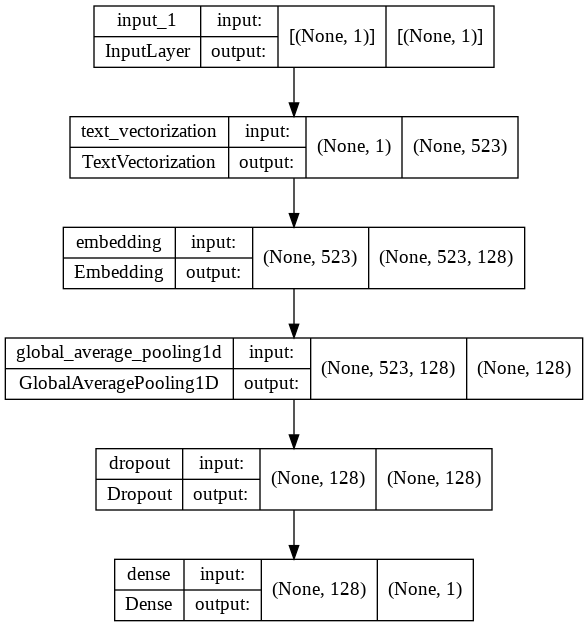

In [ ]:
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
model_history=model.fit(
    training_dataset,
    steps_per_epoch=len(training_dataset),
    epochs=12,
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)

Epoch 1/12
28/28 [==============================] - 5s 14ms/step - loss: 0.6898 - accuracy: 0.5420 - val_loss: 0.6836 - val_accuracy: 0.5636
Epoch 2/12
28/28 [==============================] - 0s 8ms/step - loss: 0.6788 - accuracy: 0.5670 - val_loss: 0.6759 - val_accuracy: 0.5636
Epoch 3/12
28/28 [==============================] - 0s 8ms/step - loss: 0.6686 - accuracy: 0.5716 - val_loss: 0.6663 - val_accuracy: 0.5636
Epoch 4/12
28/28 [==============================] - 0s 9ms/step - loss: 0.6556 - accuracy: 0.5761 - val_loss: 0.6549 - val_accuracy: 0.5864
Epoch 5/12
28/28 [==============================] - 0s 8ms/step - loss: 0.6406 - accuracy: 0.6295 - val_loss: 0.6422 - val_accuracy: 0.6955
Epoch 6/12
28/28 [==============================] - 0s 8ms/step - loss: 0.6229 - accuracy: 0.7295 - val_loss: 0.6289 - val_accuracy: 0.7000
Epoch 7/12
28/28 [==============================] - 0s 9ms/step - loss: 0.6039 - accuracy: 0.7489 - val_loss: 0.6153 - val_accuracy: 0.7227
Epoch 8/12
28/28 [=

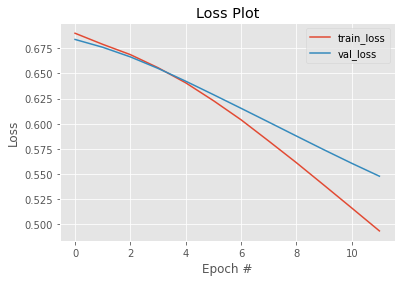

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 12), model_history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 12), model_history.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

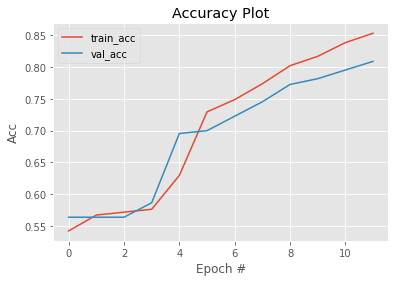

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 12), model_history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 12), model_history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [ ]:
start_time=timeit.default_timer()
model_pred_prob=model.predict(test_dataset)
model_pred=tf.squeeze(tf.round(model_pred_prob))
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)
model_accuracy=accuracy_score(ytest,model_pred)
model_precision,model_recall,model_f1_score,_=precision_recall_fscore_support(ytest,model_pred,average='weighted')

print("Accuracy : ", model_accuracy,"%")
print("Precision : ", model_precision)
print("Recall : ", model_recall)
print("F1 Score : ", model_f1_score)
print("Time per Instance : ",time_taken_per_instance,"detik")

Accuracy :  0.8090909090909091 %
Precision :  0.815503721424774
Recall :  0.8090909090909091
F1 Score :  0.8051150168817646
Time per Instance :  0.0007639625590909108 detik


# Modeling & Result Naive Bayes (MultinomialNB) + TFIDFVectorizer

In [ ]:
import nltk
nltk.download('stopwords')
modelNB=Pipeline([
    ('tf-idf',TfidfVectorizer(stop_words = nltk.corpus.stopwords.words('indonesian'))),
    ('clf',MultinomialNB())
])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
modelNB.fit(xtrain,ytrain)

Pipeline(steps=[('tf-idf',
                 TfidfVectorizer(stop_words=['ada', 'adalah', 'adanya',
                                             'adapun', 'agak', 'agaknya',
                                             'agar', 'akan', 'akankah', 'akhir',
                                             'akhiri', 'akhirnya', 'aku',
                                             'akulah', 'amat', 'amatlah',
                                             'anda', 'andalah', 'antar',
                                             'antara', 'antaranya', 'apa',
                                             'apaan', 'apabila', 'apakah',
                                             'apalagi', 'apatah', 'artinya',
                                             'asal', 'asalkan', ...])),
                ('clf', MultinomialNB())])

In [ ]:
start_time=timeit.default_timer()
modelNB_pred=modelNB.predict(xtest)
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)

model_accuracy=accuracy_score(ytest,modelNB_pred)
model_precision,model_recall,model_f1_score,_=precision_recall_fscore_support(ytest,modelNB_pred,average='weighted')

print("Accuracy : ", model_accuracy,"%")
print("Precision : ", model_precision)
print("Recall : ", model_recall)
print("F1 Score : ", model_f1_score)
print("Time per Instance : ",time_taken_per_instance,"detik")

Accuracy :  0.7045454545454546 %
Precision :  0.7400185597209333
Recall :  0.7045454545454546
F1 Score :  0.6782981328435873
Time per Instance :  0.0001746376500002291 detik
